In [1]:
import os
import time
import numpy as np
import thomsonpy.thomson_scattering.thomson_scattering_tools as thtools
import thomsonpy.data_management.formatter as fmt
import thomsonpy.data_management.fragmenter as frm
import thomsonpy.data_management.spherical_mesh.spherical_mesh as sphmesh
import thomsonpy.data_management.visualizer as vis
import thomsonpy.config.paths as paths
import thomsonpy.config.solar_imager_params as sip
import thomsonpy.config.thomson_scattering_params as tsp
import thomsonpy.constants.units as units

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
prefix = "../../"
predsci_data_filepath = prefix + paths.PREDSCI_DATA_PATH + paths.PREDSCI_FILENAME
data_filepath = f"{prefix}{paths.OCTREE_DATA_PATH}{os.path.splitext(paths.PREDSCI_FILENAME)[0]}_sphmesh.data"
dstruc_path = prefix + paths.OCTREES_PATH 

In [3]:
# DATA FRAGMENTING
print("\nStarting data formatting and fragmenting...")

ne_raw = frm.get_ne_raw(predsci_data_filepath)
data_radial = frm.get_ne_raw_coords(predsci_data_filepath, "radial")
data_theta = frm.get_ne_raw_coords(predsci_data_filepath, "theta")
data_phi = frm.get_ne_raw_coords(predsci_data_filepath, "phi")

ini_time = time.perf_counter()
mesh_data = []
mesh_data = frm.fragment(frm.selection, fmt.apply_spherical_mesh_data_format, ne_raw, data_radial, data_theta, data_phi)
fin_time = time.perf_counter()

print("Data formatting and fragmentation in", fin_time - ini_time, "seconds.")

fmt.dump(data_filepath, mesh_data)
print(f"Stored data for octree at {paths.OCTREE_DATA_PATH}")

print("Spherical mesh will have", len(mesh_data), "points")


Starting data formatting and fragmenting...

Loading datasets from ../../data/predictive_science/eclipse2021_mhd_final/corona/rho002.hdf :
 {'fakeDim0': (('fakeDim0',), (699,), 5, 0), 'fakeDim1': (('fakeDim1',), (327,), 5, 1), 'fakeDim2': (('fakeDim2',), (288,), 5, 2), 'Data-Set-2': (('fakeDim0', 'fakeDim1', 'fakeDim2'), (699, 327, 288), 5, 3)}
# POINTS =  65829024

Loading datasets from ../../data/predictive_science/eclipse2021_mhd_final/corona/rho002.hdf :
 {'fakeDim0': (('fakeDim0',), (699,), 5, 0), 'fakeDim1': (('fakeDim1',), (327,), 5, 1), 'fakeDim2': (('fakeDim2',), (288,), 5, 2), 'Data-Set-2': (('fakeDim0', 'fakeDim1', 'fakeDim2'), (699, 327, 288), 5, 3)}
RADIAL (RSOL, 1-30). # radial = 288

Loading datasets from ../../data/predictive_science/eclipse2021_mhd_final/corona/rho002.hdf :
 {'fakeDim0': (('fakeDim0',), (699,), 5, 0), 'fakeDim1': (('fakeDim1',), (327,), 5, 1), 'fakeDim2': (('fakeDim2',), (288,), 5, 2), 'Data-Set-2': (('fakeDim0', 'fakeDim1', 'fakeDim2'), (699, 327, 28

In [4]:
vis.vis_octree_data(data_filepath)

In [3]:
"""
Creates spherical mesh
"""
nd_phi = 600
nd_theta = 300
nd_radial = 400
radial_max = sip.MAX_VIS_R
mesh_data = fmt.load(data_filepath)
ini_time = time.perf_counter()
mesh = sphmesh.SphericalMesh(nd_phi, nd_theta, nd_radial, radial_max)
progress = 0
num_points = len(mesh_data)
for d in mesh_data:
    mesh.add_data(d)
    if progress % 1e6 == 0:
        print(progress / num_points * 100, "%")
    progress += 1
fin_time = time.perf_counter()
i = 0
print("SphericalMesh " + str(i + 1) + " built in", str((fin_time - ini_time) / 60), "minutes.")

sphmesh.SphericalMesh.save(mesh, dstruc_path + "sphmesh_" + str(i + 1) + ".sphmesh")
print("SphericalMesh " + str(i + 1) + " created at", paths.OCTREES_PATH)

0.0 %
9.300740562166522 %
18.601481124333045 %
27.90222168649957 %
37.20296224866609 %
46.50370281083261 %
55.80444337299914 %
65.10518393516566 %
74.40592449733218 %
83.7066650594987 %
93.00740562166521 %
SphericalMesh 1 built in 3.1313619408166686 minutes.
SphericalMesh 1 created at data/projects/test/octrees/


In [3]:
"""
Starts execution of solar corona modeling with the Predictive Science model.
"""
print("Imaging between", sip.IMAGE_MIN * units.METERS_TO_RSOL, "RSol and" , sip.IMAGE_MAX * units.METERS_TO_RSOL, "RSol.")
print("Resolution = ", sip.IMAGE_RESOLUTION / 1000, " km (", sip.IMAGE_NUM_POINTS, "x", sip.IMAGE_NUM_POINTS, ").")
x_values = np.linspace(sip.MIN_COORD, sip.MAX_COORD, sip.IMAGE_NUM_POINTS) # de - a +
#print(x_values * units.METERS_TO_RSOL)
y_values = np.linspace(sip.MIN_COORD, sip.MAX_COORD, sip.IMAGE_NUM_POINTS)[::-1] # de + a -
#print(y_values * units.METERS_TO_RSOL)
model = np.zeros((sip.IMAGE_NUM_POINTS, sip.IMAGE_NUM_POINTS))
print("# Numeric integral steps =", tsp.NUM_Z)

Imaging between [0. 0.] RSol and [2.12132034 2.12132034] RSol.
Resolution =  10000.0  km ( 148 x 148 ).
# Numeric integral steps = 8.0


In [4]:
# Quadrant 1
print("Loading SphericalMesh...")
NE_MODEL = sphmesh.SphericalMesh.load(dstruc_path + "sphmesh_1.sphmesh")
print("SphericalMesh loaded.")

num_points = sip.IMAGE_NUM_POINTS * sip.IMAGE_NUM_POINTS
print(f"Num points = {num_points}")
count = 0
for y in range(sip.IMAGE_NUM_POINTS):
    for x in range(sip.IMAGE_NUM_POINTS):
        if (x_values[x]**2 + y_values[y]**2) > tsp.SOLAR_RADIUS**2:
            # Coordinates with the center of the Sun as Origin of the Reference System.
            target = (x_values[x], y_values[y], 0)
            # Creates a ThomsonGeometry object to manage the ray - tracing across the Corona.
            TG = thtools.ThomsonGeometry(sip.SUN_CENTER, sip.OBSERVER, target, tsp.SOLAR_RADIUS)

            # Line of sight integration generating a value for the scattered light model.
            scattered_light = thtools.get_scattered_light(tsp.WAVELENGTH, tsp.T_SOL, tsp.X, TG.get_elongation(), tsp.INI_Z, tsp.FIN_Z, tsp.INCR_Z, TG, NE_MODEL)
            model[y][x] = scattered_light
        else:
            model[y][x] = 0

        # Progress
        count += 1
        if count % 1000 == 0:
            print("Progress", count / num_points * 100,"%")

fmt.dump(f"../../{paths.MODELS_PATH}predsci_test_sphmesh_148x148_8steps.np", model)


Loading SphericalMesh...
SphericalMesh loaded.
Num points = 21904
0
0
511992
511992
511992
511992
511992
511992
511992
511992
511992
511992
0
0
0
0
0
0
0
0
511992
511992
511992
511992
511992
511992
511992
511992
511992
511992
0
0
0
0
0
0
0
0
511992
511992
511992
511992
511992
511992
511992
511992
511992
511992
0
0
0
0
0
0
0
0
511992
511992
511992
511992
511992
511992
511992
511992
511992
511992
0
0
0
0
0
0
0
0
511992
511992
511992
511992
511992
511992
511992
511992
511992
511992
0
0
0
0
0
0
0
0
511992
511992
511992
511992
511992
511992
511992
511992
511992
511992
0
0
0
0
0
0
0
0
511992
511992
511992
511992
511992
511992
511992
511992
511992
511992
0
0
0
0
0
0
0
0
511992
511992
511992
511992
511992
511992
511992
511992
511992
511992
0
0
0
0
0
0
0
0
511992
511992
511992
511992
511992
511992
511992
511992
511992
511992
0
0
0
0
0
0
0
0
511992
511992
511992
511992
511992
511992
511992
511992
511992
511992
0
0
0
0
511992
511992
0
0
511992
511992
511992
511992
511992
511992
511992
511992
5119

KeyboardInterrupt: 

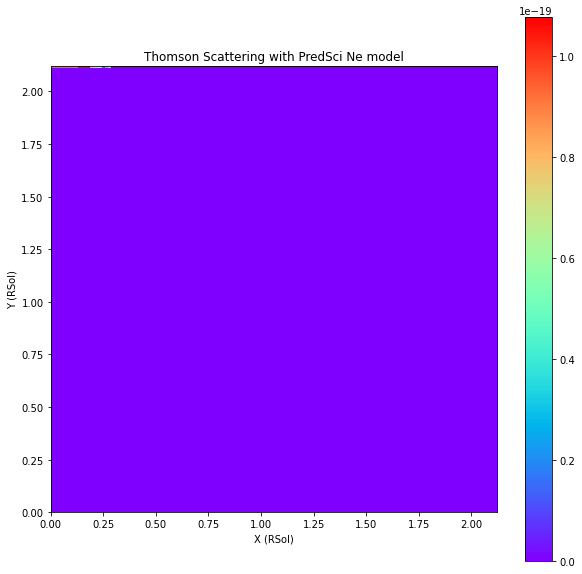

In [5]:
"""
Visualization of the ThomsonScattering.
"""
"""
cmap
['rainbow', 'nipy_spectral', 'gist_ncar', 'viridis', 'twilight', 'twilight_shifted']
"""

"""
interpolation
'none', 'antialiased', 'nearest', 'bilinear', 
'bicubic', 'spline16', 'spline36', 'hanning', 
'hamming', 'hermite', 'kaiser', 'quadric', 
'catrom', 'gaussian', 'bessel', 'mitchell', 
'sinc', 'lanczos', 'blackman'

"""

"""
interpolation_stage{'data', 'rgba'}, default: 'data'
"""
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.title("Thomson Scattering with PredSci Ne model")
plt.ylabel("Y (RSol)")
plt.xlabel("X (RSol)")
plt.imshow(model, cmap = 'rainbow', interpolation = 'nearest', extent=[sip.MIN_COORD * units.METERS_TO_RSOL, sip.MAX_COORD * units.METERS_TO_RSOL, sip.MIN_COORD * units.METERS_TO_RSOL, sip.MAX_COORD * units.METERS_TO_RSOL])
plt.colorbar()